In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, RepeatVector
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 불러오기
df = pd.read_csv('../../Data/using/dt_2.6/ByAstar_dt_2.6_modified.csv')

df = df.dropna(subset=['combination'])

# 데이터셋 분리: train_set 8 : test_set 2
train_df, test_df = train_test_split(df, shuffle=True, test_size=0.2)
# train_set을 다시 8:2로 나눠서 train_set과 validation_set을 만듦
train_df, val_df = train_test_split(train_df, shuffle=True, test_size=0.2)
# random_state=42

# 모든 시퀀스의 길이 중에서 최대 길이를 구하기
all_sequences = [eval(str(seq)) for seq in df['combination'].values]
max_seq_length = max([len(seq) for seq in all_sequences])

# 각 데이터셋에서 theta, phi, sequence 추출하고 reshape 적용
theta_train = train_df['Theta'].values.reshape(-1, 1)
phi_train = train_df['Phi'].values.reshape(-1, 1)
sequence_train = pad_sequences(train_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_val = val_df['Theta'].values.reshape(-1, 1)
phi_val = val_df['Phi'].values.reshape(-1, 1)
sequence_val = pad_sequences(val_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_test = test_df['Theta'].values.reshape(-1, 1)
phi_test = test_df['Phi'].values.reshape(-1, 1)
sequence_test = pad_sequences(test_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')


2023-09-14 14:22:56.643046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 14:22:57.575606: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 모델 정의
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')

# theta와 phi를 Concatenate
merged = Concatenate()([theta_input, phi_input])

# 시퀀스를 예측하기 위한 LSTM 레이어
repeated_vector = RepeatVector(max_seq_length)(merged)  # max_sequence_length는 시퀀스의 최대 길이

rnn_layer = LSTM(256, return_sequences=True, name='rnn_layer')(repeated_vector)

output = TimeDistributed(Dense(5, activation='softmax'), name='output_layer')(rnn_layer)

model = Model(inputs=[theta_input, phi_input], outputs=output)

# 컴파일 및 훈련
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit([theta_train, phi_train], np.expand_dims(sequence_train, -1), 
                    validation_data=([theta_val, phi_val], np.expand_dims(sequence_val, -1)), epochs=500, batch_size=64,
                    callbacks=[early_stopping])

# 검증
loss, accuracy = model.evaluate([theta_test, phi_test], np.expand_dims(sequence_test, -1))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


2023-09-14 14:22:59.354482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-14 14:22:59.395413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-14 14:22:59.395537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-14 14:22:59.397239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-14 14:22:59.397400: I tensorflow/compile

Epoch 1/500


2023-09-14 14:23:06.510241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-14 14:23:06.844714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-14 14:23:06.872013: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6d9c037eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-14 14:23:06.872047: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-09-14 14:23:06.926092: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-14 14:23:07.147930: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-14 14:23:07.28243

173/173 [==============================] - 7s 15ms/step - loss: 0.9601 - accuracy: 0.5747 - val_loss: 0.8803 - val_accuracy: 0.5861
Epoch 2/500
173/173 [==============================] - 2s 10ms/step - loss: 0.8626 - accuracy: 0.5929 - val_loss: 0.8380 - val_accuracy: 0.6353
Epoch 3/500
173/173 [==============================] - 2s 11ms/step - loss: 0.6804 - accuracy: 0.7325 - val_loss: 0.5258 - val_accuracy: 0.8001
Epoch 4/500
173/173 [==============================] - 2s 11ms/step - loss: 0.4242 - accuracy: 0.8389 - val_loss: 0.5137 - val_accuracy: 0.7895
Epoch 5/500
173/173 [==============================] - 2s 11ms/step - loss: 0.3706 - accuracy: 0.8582 - val_loss: 0.3624 - val_accuracy: 0.8651
Epoch 6/500
173/173 [==============================] - 3s 19ms/step - loss: 0.3580 - accuracy: 0.8633 - val_loss: 0.3440 - val_accuracy: 0.8778
Epoch 7/500
173/173 [==============================] - 11s 62ms/step - loss: 0.3356 - accuracy: 0.8743 - val_loss: 0.3689 - val_accuracy: 0.8624
Epo

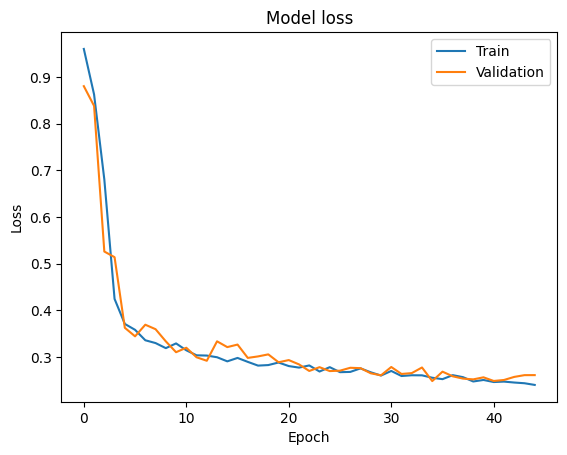

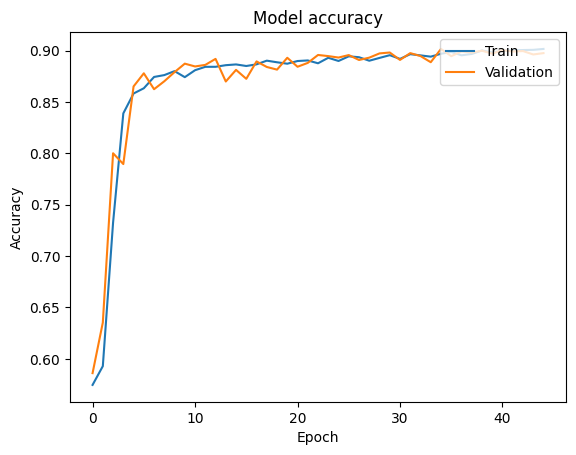

/home/yeojung/.local/lib/python3.10/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['sequence_input'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


108/108 [==============================] - 2s 14ms/step - loss: 0.2388 - accuracy: 0.9064
Test Accuracy: 90.64
Test Loss: 23.88


In [3]:
def plot_history(history):
         # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        # plt.axis([45, 70, 0, 0.01])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        # plt.axis([45, 60, 0.999, 1.0])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

def evaluate(model, theta, phi, sequence):
    loss, acc = model.evaluate({'theta_input': theta, 'phi_input': phi, 'sequence_input': sequence}, np.expand_dims(sequence, -1))
    print("Test Accuracy: {:.2f}".format(acc*100))
    print("Test Loss: {:.2f}".format(loss*100))

# 결과 그래프 그리기
plot_history(history)

# 모델 성능 평가
evaluate(model, theta_test, phi_test, sequence_test)

In [4]:
# 결과를 저장할 디렉토리 생성
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
# 모델 저장
model.save(os.path.join(models_dir, "NVspin_LSTM_model_cuda_LearningRate.h5"))

# # 모델 불러오기
# from tensorflow.keras.models import load_model
# loaded_model = load_model("SimpleRNN_model.h5")

/home/yeojung/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(theta_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([theta_samples, phi_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과를 DataFrame으로 변환
df_results = pd.DataFrame({
    'Theta': theta_samples.ravel(),
    'Phi': phi_samples.ravel(),
    'Actual Sequence': [list(seq) for seq in sequence_samples],
    'Predicted Sequence': [list(seq) for seq in predicted_sequences]
})

# 결과를 저장할 디렉토리 생성
results_dir = 'sample_LSTM'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# 결과를 CSV 파일로 저장
df_results.to_csv(os.path.join(results_dir, 'LSTM_cuda_results_LearningRate.csv'), index=False)

print("Results saved to LSTM_cuda_results_LearningRate.csv")


1/1 [==============================] - 0s 404ms/step
Results saved to LSTM_cuda_results_LearningRate.csv


In [6]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(theta_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([theta_samples, phi_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과 출력
for i in range(10):
    print(f"Sample {i + 1}:")
    print("Theta    :", theta_samples[i])
    print("Phi      :", phi_samples[i])
    print("Actual   :", sequence_samples[i])
    print("Predicted:", predicted_sequences[i])
    print("----------")


1/1 [==============================] - 0s 24ms/step
Sample 1:
Theta    : [1.66247735]
Phi      : [0.98225198]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 3 3 2 2 4 1 3 3 3 3 2 2 4 4 1 1]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1]
----------
Sample 2:
Theta    : [1.12330532]
Phi      : [3.96679722]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 4 4 1 1 3 3 2 2]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 4 4 1 1 3 3 2 2]
----------
Sample 3:
Theta    : [2.61819379]
Phi      : [0.10083578]
Actual   : [0 0 0 0 0 0 0 0 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1]
Predicted: [0 0 0 0 0 0 0 0 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1]
----------
Sample 4:
Theta    : [0.94973935]
Phi      : [2.97290295]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 2 2 4 4 1 1 3 3 2]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 2 2 4 4 1 1 3 3 2]
----------
Sample 5